### Hi-C

### 1. Dump files

In [4]:
module load Java/1.8.0
juicer_tools_path='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/'
path_to_file='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC'
out_folder='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/aligned'
for file in $path_to_file/*ENC*hic
do
    file_name=$(basename $file .hic)
    echo $file_name
    cd ${out_folder}
    echo ${file}
    for i in {1..22}
    do
        echo $i
        java -jar ${juicer_tools_path}juicer_tools.2.13.05.jar dump observed VC ${file} chr${i} chr${i} BP 5000 ${file_name}_5Kb_VC_chr${i}.txt
        sed -i "s/^/chr${i}\t/" ${file_name}_5Kb_VC_chr${i}.txt
    done
    i='X'
    java -jar ${juicer_tools_path}juicer_tools.2.13.05.jar dump observed VC ${file} chr${i} chr${i} BP 5000 ${file_name}_5Kb_VC_chr${i}.txt
    sed -i "s/^/chr${i}\t/" ${file_name}_5Kb_VC_chr${i}.txt
    i='Y'
    java -jar ${juicer_tools_path}juicer_tools.2.13.05.jar dump observed VC ${file} chr${i} chr${i} BP 5000 ${file_name}_5Kb_VC_chr${i}.txt
    sed -i "s/^/chr${i}\t/" ${file_name}_5Kb_VC_chr${i}.txt
    cat ${file_name}_5Kb_VC_chr* > ${file_name}_5Kb_VC.txt
    rm ${file_name}_5Kb_VC_chr*
done

for file in $path_to_file/*ENCF*hic
do
    file_name=$(basename $file .hic)
    echo $file_name
    cd ${out_folder}
    echo ${file}
    for i in {1..22}
    do
        echo $i
        java -jar ${juicer_tools_path}juicer_tools.2.13.05.jar dump observed SCALE ${file} chr${i} chr${i} BP 5000 ${file_name}_5Kb_SCALE_chr${i}.txt
        sed -i "s/^/chr${i}\t/" ${file_name}_5Kb_SCALE_chr${i}.txt
    done
    i='X'
    java -jar ${juicer_tools_path}juicer_tools.2.13.05.jar dump observed SCALE ${file} chr${i} chr${i} BP 5000 ${file_name}_5Kb_SCALE_chr${i}.txt
    sed -i "s/^/chr${i}\t/" ${file_name}_5Kb_SCALE_chr${i}.txt
    i='Y'
    java -jar ${juicer_tools_path}juicer_tools.2.13.05.jar dump observed SCALE ${file} chr${i} chr${i} BP 5000 ${file_name}_5Kb_SCALE_chr${i}.txt
    sed -i "s/^/chr${i}\t/" ${file_name}_5Kb_SCALE_chr${i}.txt
    cat ${file_name}_5Kb_SCALE_chr* > ${file_name}_5Kb_SCALE.txt
    rm ${file_name}_5Kb_SCALE_chr*
done

for file in $path_to_file/*ENCF*hic
do
    file_name=$(basename $file .hic)
    echo $file_name
    mkdir -p ${out_folder}/${file_name}
    cd ${out_folder}/${file_name}
    echo ${file}
    for i in {1..22}
    do
        echo $i
        java -jar ${juicer_tools_path}juicer_tools.2.13.05.jar dump observed NONE ${file} chr${i} chr${i} BP 5000 ${file_name}_5Kb_None_chr${i}.txt
        sed -i "s/^/chr${i}\t/" ${file_name}_5Kb_None_chr${i}.txt
    done
    i='X'
    java -jar ${juicer_tools_path}juicer_tools.2.13.05.jar dump observed NONE ${file} chr${i} chr${i} BP 5000 ${file_name}_5Kb_None_chr${i}.txt
    sed -i "s/^/chr${i}\t/" ${file_name}_5Kb_None_chr${i}.txt
    i='Y'
    java -jar ${juicer_tools_path}juicer_tools.2.13.05.jar dump observed NONE ${file} chr${i} chr${i} BP 5000 ${file_name}_5Kb_None_chr${i}.txt
    sed -i "s/^/chr${i}\t/" ${file_name}_5Kb_None_chr${i}.txt
    cat ${file_name}_5Kb_None_chr* > ${file_name}_5Kb_NONE.txt
    rm ${file_name}_5Kb_None_chr*
done

GM12878_ENCFF053VBX
HCT116_ENCFF750AOC
HepG2_ENCFF020DPP
IMR90_ENCFF685BLG
K562_ENCFF080DPJ


### 2. Format

In [8]:
import pyranges as pr
import pandas as pd
import numpy as np
import logging
import sys
# Load annotation
import pybiomart as pbm
# For mouse
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For fly
#dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'strand', 'external_gene_name', 'transcription_start_site', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = 'chr' + annot['Chromosome/scaffold name'].astype(str)
annot.columns=['Chromosome', 'Start', 'End', 'Strand', 'Gene','Transcription_Start_Site', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
annot.Strand[annot.Strand == 1] = '+'
annot.Strand[annot.Strand == -1] = '-'
pr_annotation = pr.PyRanges(annot.dropna(axis = 0))
# Get gene to tss mapping, take the one equal to the gene start/end location if possible otherwise take the first one
annot['TSSeqStartEnd'] = np.logical_or(annot['Transcription_Start_Site'] == annot['Start'], annot['Transcription_Start_Site'] == annot['End'])
gene_to_tss = annot[['Gene','Transcription_Start_Site']].groupby('Gene').agg(lambda x: list(map(str, x)))
startEndEq = annot[['Gene', 'TSSeqStartEnd']].groupby('Gene').agg(lambda x: list(x))
gene_to_tss['Transcription_Start_Site'] = [np.array(tss[0])[eq[0]][0] if sum(eq[0]) >= 1 else tss[0][0] for eq, tss in zip(startEndEq.values, gene_to_tss.values)]
# get gene to strand mapping
gene_to_strand = annot[['Gene', 'Strand']].groupby('Gene').agg(lambda x: list(map(str, x))[0]) 
# get gene to chromosome mapping (should be the same as the regions mapped to the gene)
gene_to_chrom = annot[['Gene', 'Chromosome']].groupby('Gene').agg(lambda x: list(map(str, x))[0])
# format annot
annot = pd.concat([gene_to_tss, gene_to_strand, gene_to_chrom], axis=1)
annot.columns = ['Start', 'Strand', 'Chromosome']
annot['Start'] =  annot['Start'].astype(int)
annot['End'] =  annot['Start'].astype(int)+1
annot['Transcription_Start_Site'] =  annot['Start'].astype(int)
annot['Gene'] = annot.index.tolist()
annot = annot[['Transcription_Start_Site', 'Gene', 'Strand']]
annot.index.name = None
tss_annotation = annot

def format_hic(path_to_hic_links,
              path_to_consensus_peaks,
              pr_annotation,
              tss_annotation,
              out_file,
              tss_space=1000):
    # Create logger
    level = logging.INFO
    log_format = '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
    handlers = [logging.StreamHandler(stream=sys.stdout)]
    logging.basicConfig(level=level, format=log_format, handlers=handlers)
    log = logging.getLogger('Hi-C')
    
    log.info('Reading file')
    hic_links = pr.read_bed(path_to_hic_links)
    hic_links = hic_links[hic_links.Name > 10]
    
    log.info('Format start and end point')
    hic_links_start = hic_links.df[['Chromosome', 'Start', 'Name']]
    hic_links_start['End'] = hic_links_start['Start']+5000
    hic_links_start = hic_links_start[['Chromosome', 'Start', 'End', 'Name']]
    hic_links_start = hic_links_start.rename(columns={'Name': 'Score'})
    hic_links_start = pr.PyRanges(hic_links_start)
    hic_links_end = hic_links.df[['Chromosome', 'End', 'Name']]
    hic_links_end['Start'] = hic_links_end['End']
    hic_links_end['End'] = hic_links_end['Start']+5000
    hic_links_end = hic_links_end[['Chromosome', 'Start', 'End', 'Name']]
    hic_links_end = hic_links_end.rename(columns={'Name': 'Score'})
    hic_links_end = pr.PyRanges(hic_links_end)
    
    log.info('Concatenating and removing duplicates')
    regions = pd.concat([hic_links_start.df[['Chromosome', 'Start', 'End']], hic_links_end.df[['Chromosome', 'Start', 'End']]], axis=0)
    regions = regions.drop_duplicates()
    
    log.info('Loading consensus peaks')
    consensus_peaks=pr.read_bed(path_to_consensus_peaks)
    consensus_peaks=consensus_peaks[['Chromosome', 'End', 'Name']]
    
    log.info('Setting TSS space')
    tss_regions = pr_annotation.df[['Chromosome', 'Transcription_Start_Site']]
    tss_regions['End'] = tss_regions['Transcription_Start_Site']+1
    tss_regions = tss_regions.rename(columns={'Transcription_Start_Site': 'Start'})
    tss_regions['Transcription_Start_Site'] = tss_regions['Start']
    tss_regions = tss_regions[['Chromosome', 'Start', 'End', 'Transcription_Start_Site']]
    tss_regions['Start'] = tss_regions['Start']-tss_space
    tss_regions['End'] = tss_regions['End']+tss_space
    tss_regions = pr.PyRanges(tss_regions)
    
    log.info('Intersecting consensus peaks with TSS')
    consensus_peaks_and_tss = pr.PyRanges(pd.concat([consensus_peaks.df,tss_regions.df]))
    consensus_peaks_and_tss = consensus_peaks_and_tss[['Chromosome', 'Start', 'End']]
    
    log.info('Select links with ATAC peaks and/or TSS')
    start_ov = hic_links_start.count_overlaps(consensus_peaks_and_tss)
    end_ov = hic_links_end.count_overlaps(consensus_peaks_and_tss)
    hic_links_start = hic_links_start[(start_ov.NumberOverlaps > 0) & (end_ov.NumberOverlaps > 0)]
    hic_links_end = hic_links_end[(start_ov.NumberOverlaps > 0) & (end_ov.NumberOverlaps > 0)]
    
    log.info('Append link ID')
    hic_links_start = hic_links_start.df
    hic_links_start['Link_id'] = range(len(hic_links_start)) 
    hic_links_start = pr.PyRanges(hic_links_start)
    hic_links_end = hic_links_end.df
    hic_links_end['Link_id'] = range(len(hic_links_end)) 
    hic_links_end = pr.PyRanges(hic_links_end)
    
    log.info('Infer Peak-TSS links for start coordinates')
    hic_links_start = hic_links_start.k_nearest(pr_annotation,  suffix='_1', ties='different', nb_cpu=10)[['Chromosome', 'Start', 'End', 'Link_id', 'Score', 'Gene', 'Distance']]
    hic_links_start = hic_links_start.df
    hic_links_start = hic_links_start.rename(columns={'Gene': 'Gene_1', 'Distance': 'Distance_to_gene_1'})
    hic_links_start = pr.PyRanges(hic_links_start).k_nearest(consensus_peaks, ties='different', nb_cpu=10)[['Chromosome', 'Start', 'End', 'Link_id', 'Score', 'Gene_1', 'Distance_to_gene_1', 'Start_b', 'End_b', 'Distance']]
    hic_links_start = hic_links_start.df
    hic_links_start = hic_links_start.rename(columns={'Start_b':'Start_1', 'End_b':'End_1', 'Distance': 'Distance_to_region_1'})
    hic_links_start = hic_links_start[(hic_links_start.Distance_to_gene_1 == 0) | (hic_links_start.Distance_to_region_1 == 0)]
    hic_links_start = hic_links_start.sort_values('Score').drop_duplicates(['Chromosome', 'Start', 'End', 'Link_id', 'Strand', 'Gene_1', 'Distance_to_gene_1', 'Start_1', 'End_1', 'Distance_to_region_1'], keep='last')
    
    log.info('Infer Peak-TSS links for end coordinates')
    hic_links_end = hic_links_end.k_nearest(pr_annotation,  suffix='_1', ties='different', nb_cpu=10)[['Chromosome', 'Start', 'End', 'Link_id', 'Score', 'Gene', 'Distance']]
    hic_links_end = hic_links_end.df
    hic_links_end = hic_links_end.rename(columns={'Gene': 'Gene_2', 'Distance': 'Distance_to_gene_2'})
    hic_links_end = pr.PyRanges(hic_links_end).k_nearest(consensus_peaks, ties='different', nb_cpu=10)[['Chromosome', 'Start', 'End', 'Link_id', 'Score', 'Gene_2', 'Distance_to_gene_2', 'Start_b', 'End_b', 'Distance']]
    hic_links_end = hic_links_end.df
    hic_links_end = hic_links_end.rename(columns={'Start_b':'Start_2', 'End_b':'End_2', 'Distance': 'Distance_to_region_2'})
    hic_links_end = hic_links_end[(hic_links_end.Distance_to_gene_2 == 0) | (hic_links_end.Distance_to_region_2 == 0)]
    hic_links_end = hic_links_end.sort_values('Score').drop_duplicates(['Chromosome', 'Start', 'End', 'Link_id', 'Strand', 'Gene_2', 'Distance_to_gene_2', 'Start_2', 'End_2', 'Distance_to_region_2'], keep='last')
    
    log.info('Join coordinates')
    hic_links_joined = pd.merge(left=hic_links_start, right=hic_links_end, left_on='Link_id', right_on='Link_id')
    hic_links_joined = hic_links_joined.loc[(hic_links_joined.Distance_to_region_1 == 0) | (hic_links_joined.Distance_to_region_2 == 0),:]
    hic_links_joined_1 = hic_links_joined.loc[(hic_links_joined.Distance_to_region_1 == 0),['Chromosome_x', 'Start_1', 'End_1', 'Gene_2', 'Score_x', 'Distance_to_gene_2']]
    hic_links_joined_1 = hic_links_joined_1.loc[(hic_links_joined_1.Distance_to_gene_2 == 0)].drop_duplicates()
    hic_links_joined_2 = hic_links_joined.loc[(hic_links_joined.Distance_to_region_2 == 0),['Chromosome_x', 'Start_2', 'End_2', 'Gene_1',  'Score_y', 'Distance_to_gene_1']]
    hic_links_joined_2 = hic_links_joined_2.loc[(hic_links_joined_2.Distance_to_gene_1 == 0)].drop_duplicates()
    hic_links_joined_1 = hic_links_joined_1.dropna()
    hic_links_joined_2 = hic_links_joined_2.dropna()
    hic_links_joined_1 = hic_links_joined_1.sort_values('Score_x').drop_duplicates(['Chromosome_x', 'Start_1', 'End_1', 'Gene_2'], keep='last')
    hic_links_joined_2 = hic_links_joined_2.sort_values('Score_y').drop_duplicates(['Chromosome_x', 'Start_2', 'End_2', 'Gene_1'], keep='last')
    hic_links_joined_1 = hic_links_joined_1.rename(columns={'Chromosome_x': 'Chromosome', 
                                                        'Start_1': 'Start',
                                                        'End_1': 'End',
                                                        'Gene_2': 'Gene',
                                                        'Score_x' : 'Score'})
    hic_links_joined_2 = hic_links_joined_2.rename(columns={'Chromosome_x': 'Chromosome', 
                                                            'Start_2': 'Start',
                                                            'End_2': 'End',
                                                            'Gene_1': 'Gene',
                                                            'Score_y' : 'Score'})

    hic_links_joined_1 = hic_links_joined_1[['Chromosome', 'Start', 'End', 'Gene', 'Score']]
    hic_links_joined_2 = hic_links_joined_2[['Chromosome', 'Start', 'End', 'Gene', 'Score']]
    hic_links_joined_final = pd.concat([hic_links_joined_1, hic_links_joined_2])
    hic_links_joined_final = hic_links_joined_final.sort_values('Score').drop_duplicates(['Chromosome', 'Start', 'End', 'Gene'], keep='last')
    
    log.info('Distance to TSS')
    hic_links_joined_final = pd.merge(left=hic_links_joined_final, right=tss_annotation, left_on='Gene', right_on='Gene')
    hic_links_joined_final['Distance_to_gene'] = hic_links_joined_final['Start'] - hic_links_joined_final['Transcription_Start_Site']
    hic_links_joined_final.Strand[hic_links_joined_final.Strand == '+'] = 1
    hic_links_joined_final.Strand[hic_links_joined_final.Strand == '-'] = -1
    hic_links_joined_final['Distance_to_gene'] = hic_links_joined_final['Distance_to_gene']*hic_links_joined_final['Strand']
    
    log.info('Saving unfiltered scores')
    hic_links_joined_final['Region_id'] = hic_links_joined_final['Chromosome'].astype(str) + ':' + hic_links_joined_final['Start'].astype(str) + '-' + hic_links_joined_final['End'].astype(str)
    hic_links_joined_final.to_csv(out_file, sep='\t', index=False)

    

/data/leuven/software/biomed/skylake_centos7/2018a/software/IPython/7.8.0-foss-2018a-Python-3.7.4/bin/ipython:14: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
/data/leuven/software/biomed/skylake_centos7/2018a/software/IPython/7.8.0-foss-2018a-Python-3.7.4/bin/ipython:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
os.environ['RAY_TMPDIR']='/scratch/leuven/313/vsc31305/ray_spill'
path_to_hic_links=['/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/aligned/IMR90_ENCFF685BLG_5Kb_SCALE.txt',
                   '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/aligned/GM12878_ENCFF053VBX_5Kb_SCALE.txt',
                   '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/aligned/HCT116_ENCFF750AOC_5Kb_SCALE.txt',
                   '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/aligned/HepG2_ENCFF020DPP_5Kb_SCALE.txt',
                   '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/aligned/K562_ENCFF080DPJ_5Kb_SCALE.txt'
                  ]
path_to_consensus_peaks='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/MACS_ATAC/iterative/peak_filtering_norm/combined_summits_final.bed'
out_file=['/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/formatted/IMR90_ENCFF685BLG_5Kb_SCALE.txt'
                   '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/formatted/GM12878_ENCFF053VBX_5Kb_SCALE.txt',
                   '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/formatted/HCT116_ENCFF750AOC_5Kb_SCALE.txt',
                   '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/formatted/HepG2_ENCFF020DPP_5Kb_SCALE.txt',
                   '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/formatted/K562_ENCFF080DPJ_5Kb_SCALE.txt'
                  ]
for i in range(len(path_to_hic_links)):
    format_hic(path_to_hic_links[i],
                  path_to_consensus_peaks,
                  pr_annotation,
                  tss_annotation,
                  out_file[i],
                  tss_space=1000)

In [57]:
## Continue here

In [21]:
import pandas as pd
hic_links = pd.read_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/HiC/formatted/HepG2_ENCFF020DPP_5Kb_SCALE.txt', sep='\t')

In [22]:
hic_links

,Chromosome,Start,End,Gene,Score,Transcription_Start_Site,Strand,Distance_to_gene,Region_id
0,chr19,21587750,21588251,ZNF493,10.000017,21397119,1,190631,chr19:21587750-21588251
1,chr19,21585171,21585672,ZNF493,10.000017,21397119,1,188052,chr19:21585171-21585672
2,chr19,21586234,21586735,ZNF493,10.000017,21397119,1,189115,chr19:21586234-21586735
3,chr19,21282787,21283288,ZNF493,10.034795,21397119,1,-114332,chr19:21282787-21283288
4,chr19,21221605,21222106,ZNF493,10.049212,21397119,1,-175514,chr19:21221605-21222106
...,...,...,...,...,...,...,...,...,...
2576842,chr16,14680470,14680971,NPIPA2,3856.234900,14748066,1,-67596,chr16:14680470-14680971
2576843,chr16,22174595,22175096,SLX1A,3885.789000,30193875,1,-8019280,chr16:22174595-22175096
2576844,chr16,22170680,22171181,SLX1A,3885.789000,30193875,1,-8023195,chr16:22170680-22171181
2576845,chr16,22174595,22175096,BOLA2B,3885.789000,30194306,-1,8019711,chr16:22174595-22175096


In [23]:
hic_links['Distance_to_gene'].abs().astype(int).describe()

count    2.576847e+06
mean     1.195439e+06
std      8.566253e+06
min      0.000000e+00
25%      4.118500e+04
50%      9.298800e+04
75%      1.792700e+05
max      2.466644e+08
Name: Distance_to_gene, dtype: float64

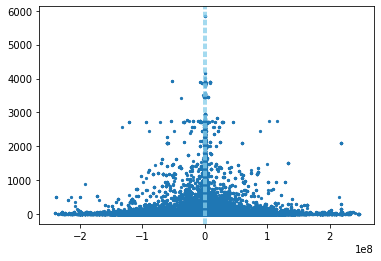

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(hic_links.Distance_to_gene, hic_links.Score, s=5)
plt.axvline(x=-150000, color='skyblue', linestyle='--')
plt.axvline(x=150000, color='skyblue', linestyle='--')

(-5000000.0, 5000000.0)

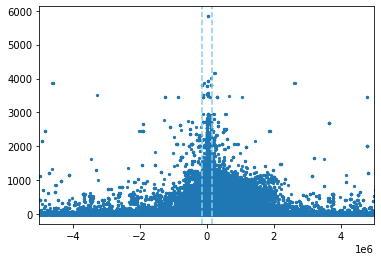

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(hic_links.Distance_to_gene, hic_links.Score, s=5)
plt.axvline(x=-150000, color='skyblue', linestyle='--')
plt.axvline(x=150000, color='skyblue', linestyle='--')
plt.xlim(-5000000, 5000000)

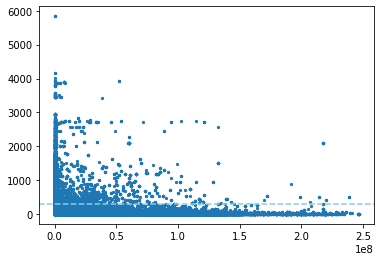

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(hic_links.Distance_to_gene.abs(), hic_links.Score, s=5)
plt.axhline(y=300, color='skyblue', linestyle='--')

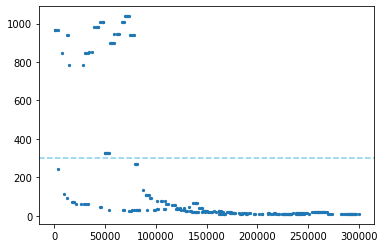

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(hic_links[hic_links.Gene == 'HNF4A'].Distance_to_gene.abs(), 
            hic_links[hic_links.Gene == 'HNF4A'].Score, s=5)
plt.axhline(y=300, color='skyblue', linestyle='--')
#plt.xlim(-100, 800000)

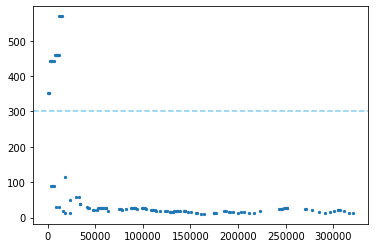

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(hic_links[hic_links.Gene == 'GLUL'].Distance_to_gene.abs(), 
            hic_links[hic_links.Gene == 'GLUL'].Score, s=5)
plt.axhline(y=300, color='skyblue', linestyle='--')
#plt.xlim(-100, 800000)

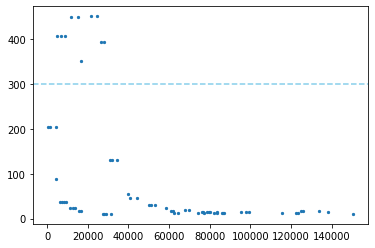

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(hic_links[hic_links.Gene == 'ALDOB'].Distance_to_gene.abs(), 
            hic_links[hic_links.Gene == 'ALDOB'].Score, s=5)
plt.axhline(y=300, color='skyblue', linestyle='--')

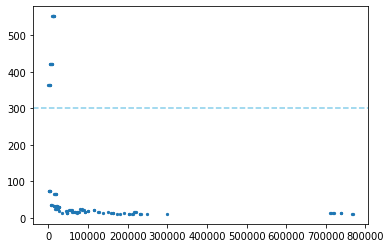

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(hic_links[hic_links.Gene == 'TBX3'].Distance_to_gene.abs(), 
            hic_links[hic_links.Gene == 'TBX3'].Score, s=5)
plt.axhline(y=300, color='skyblue', linestyle='--')

In [68]:
hic_links_joined_final[hic_links_joined_final.Region_id == 'chr2:91116810-91117310']

,Chromosome,Start,End,Gene,Score,Transcription_Start_Site,Strand,Distance_to_gene,Region_id
950847,chr2,91116810,91117310,Tubgcp4,13.505593,121171215,1,-30054405,chr2:91116810-91117310
1497749,chr2,91116810,91117310,Pip4k2a,15.472287,18998126,-1,-72118684,chr2:91116810-91117310
4344896,chr2,91116810,91117310,Celf1,22.187525,90940397,1,176413,chr2:91116810-91117310
8689780,chr2,91116810,91117310,Ambra1,18.949057,91730134,1,-613324,chr2:91116810-91117310
8701015,chr2,91116810,91117310,Dnajc10,16.040670,80315466,1,10801344,chr2:91116810-91117310
9650613,chr2,91116810,91117310,Tspan18,18.397024,93334487,-1,2217677,chr2:91116810-91117310
11069022,chr2,91116810,91117310,Zscan29,13.505593,121171125,-1,30054315,chr2:91116810-91117310
15319660,chr2,91116810,91117310,Spi1,17.350230,91082390,1,34420,chr2:91116810-91117310
18885772,chr2,91116810,91117310,Ddb2,36.479960,91236982,-1,120172,chr2:91116810-91117310
19452780,chr2,91116810,91117310,Olfr1217,29.558538,89032065,-1,-2084745,chr2:91116810-91117310


In [69]:
hic_links_joined_final_filt_filt = hic_links_joined_final_filt[hic_links_joined_final_filt.Score > 1]

In [70]:
hic_links_joined_final_filt_filt['Distance_to_gene'].abs().astype(int).describe()

count    3.280772e+06
mean     1.370261e+07
std      1.977739e+07
min      0.000000e+00
25%      4.822528e+05
50%      3.441574e+06
75%      2.040836e+07
max      1.237359e+08
Name: Distance_to_gene, dtype: float64

In [71]:
hic_links_joined_final_filt_filt.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/hic_links_woverlap_wregionid_filt_filt1.tsv', sep='\t', index=False)

In [72]:
hic_links_joined_final_filt_filt = hic_links_joined_final_filt[hic_links_joined_final_filt.Score > 5]

In [73]:
hic_links_joined_final_filt_filt['Distance_to_gene'].abs().astype(int).describe()

count    7.510330e+05
mean     1.089862e+07
std      1.835302e+07
min      0.000000e+00
25%      1.692690e+05
50%      1.326117e+06
75%      1.390006e+07
max      1.237359e+08
Name: Distance_to_gene, dtype: float64

In [74]:
hic_links_joined_final_filt_filt = hic_links_joined_final_filt[hic_links_joined_final_filt.Score > 10]

In [75]:
hic_links_joined_final_filt_filt.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/hic_links_woverlap_wregionid_filt_filt10.tsv', sep='\t', index=False)

In [80]:
file = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/hic_links_woverlap_wregionid_filt_filt10.tsv'
cmap_pos = 'Reds'
df = pd.read_csv(file, sep='\t')
chrom = df.Chromosome
chromStart = df.Start
chromEnd = df.End
genes = df.Gene
sourceChrom = chrom
sourceStart = np.array(list(map(int, chromStart + (chromEnd - chromStart)/2 - 1)))
sourceEnd   = np.array(list(map(int, chromStart + (chromEnd - chromStart)/2)))
sourceName = chrom + ':' + chromStart.astype(str) + '-' + chromEnd.astype(str)
targetChrom = chrom
targetStart = df.Transcription_Start_Site
targetEnd   = list(map(str,np.array(list(map(int, targetStart))) + np.array([1 if strand == '1' else -1 for strand in df['Strand'].values])))
targetName = chrom + ':' + targetStart.astype(str) + '-' + targetEnd
from matplotlib import cm
from matplotlib.colors import Normalize
df['Score'][df['Score'] > 25] = 25
score = (df['Score']/df['Score'].max()*1000).astype(int)
norm = Normalize(vmin = 0, vmax = 1000)
color = [','.join(map(str, color_list)) for color_list in getattr(cm, cmap_pos)(norm(score), bytes = True)[:,0:3]]

In [81]:
df_interact = pd.DataFrame(
                                data = {
                                    'chrom':        chrom,
                                    'chromStart':   chromStart,
                                    'chromEnd':     chromEnd,
                                    'name':         genes,
                                    'score':        score,
                                    'value':        df['Score'].astype(int),
                                    'exp':          np.repeat('.', len(df)),
                                    'color':        color,
                                    'sourceChrom':  sourceChrom,
                                    'sourceStart':  sourceStart,
                                    'sourceEnd':    sourceEnd,
                                    'sourceName':   sourceName,
                                    'sourceStrand': np.repeat('.', len(df)),
                                    'targetChrom':  targetChrom,
                                    'targetStart':  targetStart,
                                    'targetEnd':    targetEnd,
                                    'targetName':   targetName,
                                    'targetStrand': np.repeat('.', len(df))
                                }
                            )

In [82]:
df_interact

,chrom,chromStart,chromEnd,name,score,value,exp,color,sourceChrom,sourceStart,sourceEnd,sourceName,sourceStrand,targetChrom,targetStart,targetEnd,targetName,targetStrand
0,chr9,42057309,42057809,Hepacam,403,10,.,"251,136,104",chr9,42057558,42057559,chr9:42057309-42057809,.,chr9,37367351,37367350,chr9:37367351-37367350,.
1,chr9,42055362,42055862,Hepacam,403,10,.,"251,136,104",chr9,42055611,42055612,chr9:42055362-42055862,.,chr9,37367351,37367350,chr9:37367351-37367350,.
2,chr9,42054799,42055299,Hepacam,403,10,.,"251,136,104",chr9,42055048,42055049,chr9:42054799-42055299,.,chr9,37367351,37367350,chr9:37367351-37367350,.
3,chr9,21212517,21213017,Hepacam,434,10,.,"251,126,94",chr9,21212766,21212767,chr9:21212517-21213017,.,chr9,37367351,37367350,chr9:37367351-37367350,.
4,chr9,21213569,21214069,Hepacam,434,10,.,"251,126,94",chr9,21213818,21213819,chr9:21213569-21214069,.,chr9,37367351,37367350,chr9:37367351-37367350,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382591,chr4,62683215,62683715,Mup12,1000,25,.,"103,0,12",chr4,62683464,62683465,chr4:62683215-62683715,.,chr4,60741326,60741325,chr4:60741326-60741325,.
382592,chr4,62681413,62681913,Mup12,1000,25,.,"103,0,12",chr4,62681662,62681663,chr4:62681413-62681913,.,chr4,60741326,60741325,chr4:60741326-60741325,.
382593,chr5,26007175,26007675,5031410I06Rik,1000,25,.,"103,0,12",chr5,26007424,26007425,chr5:26007175-26007675,.,chr5,26105362,26105361,chr5:26105362-26105361,.
382594,chr14,57664093,57664593,Gm21977,1000,25,.,"103,0,12",chr14,57664342,57664343,chr14:57664093-57664593,.,chr14,42853477,42853476,chr14:42853477-42853476,.


In [83]:
df_interact = df_interact.sort_values(by = ['chrom', 'chromStart'])
ucsc_track_name = 'Hi-C_10'
ucsc_description = 'Hi-C links with a score above 10'
outfile = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/hic_links_woverlap_wregionid_filt_filt10_UCSC_25.tsv'
with open(outfile, 'w') as f:
    f.write('track type=interact name="{}" description="{}" useScore=0 maxHeightPixels=200:100:50 visibility=full\n'.format(ucsc_track_name, ucsc_description))
    df_interact.to_csv(f, header=False, index = False, sep = '\t')

In [ ]:
hic_links_joined_final_filt.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/hic_links_woverlap_wregionid_filt.tsv', sep='\t', index=False)

In [2]:
# Same but using 5kb bins again
import pyranges as pr
import pandas as pd
#file = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/hic_links_woverlap_wregionid_filt_filt10.tsv'
file = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/hic_links_woverlap_wregionid_filt.tsv'
cmap_pos = 'Reds'
df = pd.read_csv(file, sep='\t')
pr_df = pr.PyRanges(df)
bins = pr.read_bed('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/TAD_bins_5kb.bed')
pr_df = pr_df.k_nearest(bins,  suffix='_1', ties='different')
pr_df = pr_df[pr_df.Distance == 0]
df = pr_df.df
df['HiC_bin'] = df['Chromosome'].astype(str) + ':' + df['Start'].astype(str) + '-' + + df['End'].astype(str)
#df = df.sort_values('Score').drop_duplicates(['Chromosome', 'Start_b', 'End_b', 'Gene'], keep='last')
#df['Start'] = df['Start_b']
#df['End'] = df['End_b']

/opt/venv/lib/python3.8/site-packages/pyranges/methods/k_nearest.py:98: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  d2 = d2.drop("Chromosome", 1)


,Chromosome,Start,End,Gene,Score,Transcription_Start_Site,Strand,Distance_to_gene,Region_id,Start_b,End_b,Distance
0,chr1,64444755,64445255,4931408C20Rik,0.039877,26687460,-1,-37757295,chr1:64444755-64445255,64440000,64445000,0
1,chr1,64444755,64445255,4931408C20Rik,0.039877,26687460,-1,-37757295,chr1:64444755-64445255,64445000,64450000,0
2,chr1,64445358,64445858,4931408C20Rik,0.039877,26687460,-1,-37757898,chr1:64445358-64445858,64445000,64450000,0
3,chr1,64445935,64446435,4931408C20Rik,0.039877,26687460,-1,-37758475,chr1:64445935-64446435,64445000,64450000,0
4,chr1,64448669,64449169,4931408C20Rik,0.039877,26687460,-1,-37761209,chr1:64448669-64449169,64445000,64450000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17979518,chrX,20863329,20863829,Xlr3b,50.045235,73192222,1,-52328893,chrX:20863329-20863829,20860000,20865000,0
17979519,chrX,20861965,20862465,Xlr3b,50.045235,73192222,1,-52330257,chrX:20861965-20862465,20860000,20865000,0
17979520,chrX,20861446,20861946,Xlr3b,50.045235,73192222,1,-52330776,chrX:20861446-20861946,20860000,20865000,0
17979521,chrX,20859748,20860248,Xlr3b,50.045235,73192222,1,-52332474,chrX:20859748-20860248,20855000,20860000,0


In [4]:
df['HiC_bin'] = df['Chromosome'].astype(str) + ':' + df['Start'].astype(str) + '-' + + df['End'].astype(str)
df.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/hic_links_woverlap_wregionid_filt_whicbin.tsv', sep='\t', index=False)

In [103]:
# Same but using 5kb bins again
chrom = df.Chromosome
chromStart = df.Start
chromEnd = df.End
genes = df.Gene
sourceChrom = chrom
sourceStart = np.array(list(map(int, chromStart + (chromEnd - chromStart)/2 - 1)))
sourceEnd   = np.array(list(map(int, chromStart + (chromEnd - chromStart)/2)))
sourceName = chrom.astype(str) + ':' + chromStart.astype(str) + '-' + chromEnd.astype(str)
targetChrom = chrom
targetStart = df.Transcription_Start_Site
targetEnd   = list(map(str,np.array(list(map(int, targetStart))) + np.array([1 if strand == '1' else -1 for strand in df['Strand'].values])))
targetName = chrom.astype(str) + ':' + targetStart.astype(str) + '-' + targetEnd
from matplotlib import cm
from matplotlib.colors import Normalize
df['Score'][df['Score'] > 25] = 25
score = (df['Score']/df['Score'].max()*1000).astype(int)
norm = Normalize(vmin = 0, vmax = 1000)
color = [','.join(map(str, color_list)) for color_list in getattr(cm, cmap_pos)(norm(score), bytes = True)[:,0:3]]

In [104]:
df_interact = pd.DataFrame(
                                data = {
                                    'chrom':        chrom,
                                    'chromStart':   chromStart,
                                    'chromEnd':     chromEnd,
                                    'name':         genes,
                                    'score':        score,
                                    'value':        df['Score'].astype(int),
                                    'exp':          np.repeat('.', len(df)),
                                    'color':        color,
                                    'sourceChrom':  sourceChrom,
                                    'sourceStart':  sourceStart,
                                    'sourceEnd':    sourceEnd,
                                    'sourceName':   sourceName,
                                    'sourceStrand': np.repeat('.', len(df)),
                                    'targetChrom':  targetChrom,
                                    'targetStart':  targetStart,
                                    'targetEnd':    targetEnd,
                                    'targetName':   targetName,
                                    'targetStrand': np.repeat('.', len(df))
                                }
                            )

In [105]:
df_interact = df_interact.sort_values(by = ['chrom', 'chromStart'])
ucsc_track_name = 'Hi-C_10_bin-based'
ucsc_description = 'Hi-C links with a score above 10, bin based'
outfile = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/SNARE_mouse/data/hic/mega/aligned/hic_links_woverlap_wregionid_filt_filt10_UCSC_25_binbased.tsv'
with open(outfile, 'w') as f:
    f.write('track type=interact name="{}" description="{}" useScore=0 maxHeightPixels=200:100:50 visibility=full\n'.format(ucsc_track_name, ucsc_description))
    df_interact.to_csv(f, header=False, index = False, sep = '\t')